<a href="https://colab.research.google.com/github/AMIRMOHAMMAD-OSS/Bioinformatics/blob/main/MV_VAE_V1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cd /content/aiupred
!unzip /content/aiupred/aiupred.zip

Archive:  /content/aiupred/aiupred.zip
   creating: data/
  inflating: data/decoder.pt         
  inflating: data/embedding.pt       
   creating: __pycache__/
  inflating: __pycache__/aiupred_lib.cpython-311.pyc  
  inflating: __pycache__/aiupred_lib.cpython-310.pyc  
  inflating: aiupred.py              
  inflating: aiupred_lib.py          
  inflating: readme.md               
  inflating: requirements.txt        
  inflating: test.fasta              


#Data processing

In [ ]:
from __future__ import annotations
from transformers import AutoTokenizer, AutoModel
import json
from pathlib import Path
from typing import List, Dict, Any, Optional, Tuple
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from transformers import EsmModel, EsmTokenizer

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("nrps_parser")

import aiupred_lib

MIN_IUPRED_LEN = 11


def safe_json_load(x: Any) -> Optional[Any]:
    try:
        if pd.isna(x):
            return None
        return json.loads(x)
    except Exception:
        return None


def calculate_sequence_charge(sequence: str) -> np.ndarray:
    sequence = (sequence or "").upper()
    definite = {"D": -1, "E": -1, "K": 1, "R": 1, "N_term": 1, "C_term": -1}
    out = []
    for i, aa in enumerate(sequence):
        c = definite.get(aa, 0)
        if i == 0:
            c += definite["N_term"]
        elif i == len(sequence) - 1:
            c += definite["C_term"]
        out.append(c)
    return np.asarray(out, dtype=float)


def aromatic_clustering(seq: str) -> float:
    arom = {"Y", "W", "F"}
    idxs = [i for i, aa in enumerate(seq or "") if aa in arom]
    n = len(idxs)
    if n <= 1:
        return 0.0
    s = 0.0
    pairs = 0
    for i in range(n - 1):
        for j in range(i + 1, n):
            d = abs(idxs[j] - idxs[i])
            if d > 0:
                s += 1.0 / d
                pairs += 1
    return float(s / max(pairs, 1))


def PPII_propensity(seq: str) -> List[float]:
    table = {
        'I': 0.39, 'V': 0.39, 'L': 0.24, 'F': 0.17, 'C': 0.25, 'M': 0.36, 'A': 0.37, 'G': 0.13,
        'T': 0.32, 'S': 0.24, 'W': 0.25, 'Y': 0.25, 'P': 1.00, 'H': 0.20, 'E': 0.42, 'Q': 0.53,
        'D': 0.30, 'N': 0.27, 'K': 0.56, 'R': 0.38
    }
    return [table.get(a, 0.0) for a in (seq or "")]


def safe_predict_iupred(seq: str, embedding_model=None, regression_model=None, device: str = "cpu") -> np.ndarray:
    seq = str(seq or "")
    if len(seq) < MIN_IUPRED_LEN:
        return np.full(len(seq), 0.4, dtype=float)
    try:
        scores = aiupred_lib.predict_disorder(seq, embedding_model, regression_model, device)
        scores = np.asarray(scores, dtype=float)
        if scores.size == 0:
            raise ValueError("empty iupred output")
        return scores
    except Exception as e:
        logger.warning(f"IUPred failed (len={len(seq)}): {e}. Using fallback 0.4.")
        return np.full(len(seq), 0.4, dtype=float)


def compute_handcrafted_features(sequence: str,region_type: str,embedding_model=None,regression_model=None,device: str = "cpu",dim: int = 15,) -> np.ndarray:
    seq = str(sequence or "")
    feats: List[float]

    if region_type in ["A-T", "T-C"]:
        ius = safe_predict_iupred(seq, embedding_model, regression_model, device)
        mean_iupred = float(ius.mean()) if ius.size else 0.0
        charges = calculate_sequence_charge(seq)
        mean_charge = float(charges.mean()) if charges.size else 0.0
        pp2 = float(np.mean(PPII_propensity(seq))) if seq else 0.0
        feats = [len(seq), mean_charge, mean_iupred, aromatic_clustering(seq), pp2]

    elif region_type == "A":
        feats = [1.0 if i < len(seq) and seq[i] in "AILV" else 0.0 for i in range(10)]

    elif region_type == "T":
        feats = [1.0 if "S" in seq else 0.0]

    elif region_type == "C":
        charges = calculate_sequence_charge(seq)
        mean_charge = float(charges.mean()) if charges.size else 0.0
        feats = [1.0 if "HH" in seq else 0.0, mean_charge]

    else:
        feats = []

    if len(feats) < dim:
        feats += [0.0] * (dim - len(feats))
    else:
        feats = feats[:dim]

    return np.asarray(feats, dtype=float)

ESM2_MODEL_NAME = "facebook/esm2_t33_650M_UR50D"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = EsmTokenizer.from_pretrained(ESM2_MODEL_NAME)
esm_model = EsmModel.from_pretrained(ESM2_MODEL_NAME).eval().to(DEVICE)
HIDDEN = esm_model.config.hidden_size


class AttentionPooling(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.attn = nn.Linear(dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        scores = self.attn(x).squeeze(-1)
        weights = torch.softmax(scores, dim=0)
        pooled = torch.sum(weights.unsqueeze(-1) * x, dim=0)
        return pooled


attn_pool = AttentionPooling(HIDDEN).to(DEVICE)

MOTIF_POS: Dict[str, List[int]] = {
    "A": [],
    "T": [],
    "C": [],
}


@torch.no_grad()
def esm2_pool(seq: str) -> torch.Tensor:
    if not seq or not seq.strip():
        return torch.zeros(HIDDEN, device=DEVICE)

    toks = tokenizer(seq, return_tensors="pt", add_special_tokens=True)
    toks = {k: v.to(DEVICE) for k, v in toks.items()}
    out = esm_model(**toks)
    tok = out.last_hidden_state.squeeze(0)
    if tok.size(0) >= 2:
        tok = tok[1:-1]
    pooled = attn_pool(tok)
    return pooled


@torch.no_grad()
def motif_pool(emb: torch.Tensor, motif_positions: List[int]) -> torch.Tensor:
    if motif_positions is None or len(motif_positions) == 0:
        return torch.zeros(HIDDEN, device=DEVICE)
    return torch.zeros(HIDDEN, device=DEVICE)


@torch.no_grad()
def region_vector( seq: str, handcrafted: np.ndarray, region_name: str, concat_motif: bool = False,) -> np.ndarray:
    hf = torch.as_tensor(handcrafted, dtype=torch.float32, device=DEVICE)
    esm_vec = esm2_pool(seq)  # (HIDDEN,)

    if concat_motif:
        motif_vec = motif_pool(esm_vec, MOTIF_POS.get(region_name, []))  # zeros for now
        full = torch.cat([hf, esm_vec, motif_vec], dim=-1)
    else:
        full = torch.cat([hf, esm_vec], dim=-1)

    return full.detach().cpu().numpy()

def parse_excel(data_file: str | Path,embedding_model=None,regression_model=None,device_iupred: str = "cpu",feature_dim: int = 15,concat_motif: bool = False,) -> Dict[str, Any]:
    df = pd.read_excel(data_file)
    df = df[df["Between_T_C_Domains"].apply(lambda x: len(safe_json_load(x) or []) == 1)]
    df = df[df["Between_A_T_Domains"].apply(lambda x: len(safe_json_load(x) or []) == 1)]

    modules: List[List[str]] = []
    features_list: List[np.ndarray] = []
    mask_list: List[np.ndarray] = []
    labels: List[int] = []
    bgc_ids: List[Any] = []

    regions = ["A", "A-T", "T", "T-C", "C"]

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Parsing modules"):
        module_seqs = [
            row["A_Sequence"],
            "",
            row["T_Sequence"],
            "",
            row["C_Sequence"],
        ]

        at_info = safe_json_load(row["Between_A_T_Domains"])
        module_seqs[1] = (at_info[0].get("Sequence", "") if at_info else "GS" * 20)

        tc_info = safe_json_load(row["Between_T_C_Domains"])
        module_seqs[3] = (tc_info[0].get("Sequence", "") if tc_info else "PP" * 20)

        modules.append(module_seqs)
        labels.append(1)
        bgc_ids.append(row.get("BGC_ID", None))
        region_vecs: List[np.ndarray] = []
        region_mask: List[float] = []
        for seq, reg in zip(module_seqs, regions):
            handcrafted = compute_handcrafted_features(seq, reg, embedding_model, regression_model, device_iupred, feature_dim)
            vec = region_vector(seq, handcrafted, reg, concat_motif=concat_motif)
            region_vecs.append(vec)
            region_mask.append(0.0 if np.allclose(vec, 0.0) else 1.0)

        region_mat = np.stack(region_vecs, axis=0)
        features_list.append(region_mat)
        mask_list.append(np.asarray(region_mask, dtype=float))

    features = np.stack(features_list, axis=0)
    mask = np.stack(mask_list, axis=0)

    return {
        "sequences": modules,
        "features": features,
        "mask": mask,
        "labels": np.asarray(labels, dtype=int),
        "bgc_ids": np.asarray(bgc_ids),
        "d_in": features.shape[-1],
    }


if __name__ == "__main__":

    emb_model, reg_model, iupred_device = aiupred_lib.init_models()

    data_file = Path("/content/drive/MyDrive/NRPS-dataet/MiBIG/MiBIG_tridomains_extracted.xlsx")
    data = parse_excel(
        data_file,
        embedding_model=emb_model,
        regression_model=reg_model,
        device_iupred=iupred_device,
        feature_dim=15,
        concat_motif=False,
    )

    print(f"Parsed {len(data['sequences'])} modules")
    print(f"Feature tensor shape: {data['features'].shape}")
    print(f"Mask shape: {data['mask'].shape}")
    print(f"Per-region dim (d_in): {data['d_in']}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Parsing modules: 100%|██████████| 1821/1821 [15:51<00:00,  1.91it/s]

Parsed 1821 modules
Feature tensor shape: (1821, 5, 1295)
Mask shape: (1821, 5)
Per-region dim (d_in): 1295


#Model

In [ ]:
from __future__ import annotations
import math
import os
from dataclasses import dataclass
from typing import Optional, Dict, Any, Tuple
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

@dataclass
class VAEConfig:
    d_in: int
    n_regions: int = 5
    d_model: int = 256
    n_heads: int = 8
    n_layers: int = 2
    d_ff: int = 512
    dropout: float = 0.1

    latent_dim: int = 64
    beta: float = 1.0
    kl_warmup_steps: int = 2000

    decoder_hidden: int = 256
    per_region_decoders: bool = False

    lr: float = 1e-3
    weight_decay: float = 1e-4
    batch_size: int = 64
    num_epochs: int = 30

    use_probe: bool = False
    probe_weight: float = 0.1

    device: str = "cuda" if torch.cuda.is_available() else "cpu"

class NRPSDataset(Dataset):
    def __init__(self, features: np.ndarray, mask: Optional[np.ndarray] = None):
        """
        features: (N, 5, D)
        mask: (N, 5) 1=present, 0=missing (optional). If None, assume all ones.
        """
        assert features.ndim == 3
        self.x = torch.from_numpy(features).float()
        if mask is None:
            self.m = torch.ones(self.x.shape[:2], dtype=torch.float32)
        else:
            self.m = torch.from_numpy(mask).float()

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.m[idx]


class SegmentPositionalEmbedding(nn.Module):
    def __init__(self, n_regions: int, d_model: int):
        super().__init__()
        self.proj = nn.Linear(1, d_model)
        self.segment = nn.Embedding(n_regions, d_model)
        self.pos = nn.Embedding(n_regions, d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, R, _ = x.shape
        seg_ids = torch.arange(R, device=x.device).unsqueeze(0).expand(B, R)
        pos_ids = torch.arange(R, device=x.device).unsqueeze(0).expand(B, R)
        return self.segment(seg_ids) + self.pos(pos_ids)


class MultiRegionEncoder(nn.Module):
    def __init__(self, cfg: VAEConfig):
        super().__init__()
        self.cfg = cfg
        self.input_proj = nn.Linear(cfg.d_in, cfg.d_model)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=cfg.d_model,
            nhead=cfg.n_heads,
            dim_feedforward=cfg.d_ff,
            dropout=cfg.dropout,
            batch_first=True,
            activation="gelu",
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=cfg.n_layers)
        self.segpos = SegmentPositionalEmbedding(cfg.n_regions, cfg.d_model)
        self.layernorm = nn.LayerNorm(cfg.d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, cfg.d_model) * 0.02)
        self.to_mu = nn.Linear(cfg.d_model, cfg.latent_dim)
        self.to_logvar = nn.Linear(cfg.d_model, cfg.latent_dim)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        B, R, _ = x.shape
        h = self.input_proj(x)
        h = h + self.segpos(x)
        cls = self.cls_token.expand(B, 1, -1)
        h = torch.cat([cls, h], dim=1)

        src_key_padding_mask = None
        if mask is not None:
            pad = (mask <= 0).bool()
            pad = torch.cat([torch.zeros(B, 1, device=pad.device, dtype=torch.bool), pad], dim=1)
            src_key_padding_mask = pad

        h = self.encoder(h, src_key_padding_mask=src_key_padding_mask)
        h_cls = self.layernorm(h[:, 0])
        mu = self.to_mu(h_cls)
        logvar = self.to_logvar(h_cls)
        return mu, logvar, h[:, 1:]

class MultiRegionDecoder(nn.Module):
    def __init__(self, cfg: VAEConfig):
        super().__init__()
        self.cfg = cfg
        self.from_z = nn.Sequential(
            nn.Linear(cfg.latent_dim, cfg.decoder_hidden),
            nn.GELU(),
            nn.Linear(cfg.decoder_hidden, cfg.n_regions * cfg.d_model),
            nn.GELU(),
        )
        if cfg.per_region_decoders:
            self.decoders = nn.ModuleList(
                [nn.Sequential(
                    nn.Linear(cfg.d_model, cfg.decoder_hidden),
                    nn.GELU(),
                    nn.Linear(cfg.decoder_hidden, cfg.d_in)
                ) for _ in range(self.cfg.n_regions)]
            )
        else:
            self.shared = nn.Sequential(
                nn.Linear(cfg.d_model, cfg.decoder_hidden),
                nn.GELU(),
                nn.Linear(cfg.decoder_hidden, cfg.d_in)
            )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        B = z.size(0)
        H = self.from_z(z)  # (B, R*d_model)
        H = H.view(B, self.cfg.n_regions, self.cfg.d_model)
        if self.cfg.per_region_decoders:
            outs = []
            for r in range(self.cfg.n_regions):
                outs.append(self.decoders[r](H[:, r, :]))
            x_hat = torch.stack(outs, dim=1)
        else:
            x_hat = self.shared(H.view(-1, self.cfg.d_model))
            x_hat = x_hat.view(B, self.cfg.n_regions, self.cfg.d_in)
        return x_hat

class MultiInputVAE(nn.Module):
    def __init__(self, cfg: VAEConfig):
        super().__init__()
        self.cfg = cfg
        self.encoder = MultiRegionEncoder(cfg)
        self.decoder = MultiRegionDecoder(cfg)
        if cfg.use_probe:
            self.probe = nn.Sequential(
                nn.Linear(cfg.latent_dim, 64), nn.GELU(), nn.Linear(64, 1)
            )
        else:
            self.probe = None

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        mu, logvar, _ = self.encoder(x, mask)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        out = {"x_hat": x_hat, "mu": mu, "logvar": logvar, "z": z}
        if self.probe is not None:
            out["probe"] = self.probe(z).squeeze(-1)
        return out

class ELBOLoss(nn.Module):
    def __init__(self, cfg: VAEConfig):
        super().__init__()
        self.cfg = cfg

    def forward(self, x: torch.Tensor, out: Dict[str, torch.Tensor], mask: Optional[torch.Tensor] = None,
                step: int = 0, y: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, Dict[str, float]]:
        x_hat, mu, logvar = out["x_hat"], out["mu"], out["logvar"]
        if mask is not None:
            m = mask.unsqueeze(-1)  # (B, R, 1)
            recon = F.mse_loss(x_hat * m, x * m, reduction="sum") / (m.sum() + 1e-8)
        else:
            recon = F.mse_loss(x_hat, x, reduction="mean")
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
        beta = min(1.0, self.cfg.beta * (step / max(1, self.cfg.kl_warmup_steps)))
        loss = recon + beta * kl
        logs = {"loss": float(loss.item()), "recon": float(recon.item()), "kl": float(kl.item()), "beta": float(beta)}
        if (y is not None) and ("probe" in out):
            bce = F.binary_cross_entropy_with_logits(out["probe"], y.float())
            loss = loss + self.cfg.probe_weight * bce
            logs["probe_bce"] = float(bce.item())
        return loss, logs

def train_vae(cfg: VAEConfig, train_set: NRPSDataset, test_set: Optional[NRPSDataset] = None,
              y_train: Optional[torch.Tensor] = None, y_test: Optional[torch.Tensor] = None,
              ckpt_path: Optional[str] = None, use_early_stopping: bool = True) -> Tuple[MultiInputVAE, Dict[str, Any]]:
    model = MultiInputVAE(cfg).to(cfg.device)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    crit = ELBOLoss(cfg)

    dl_train = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True, drop_last=False)
    dl_test = DataLoader(test_set, batch_size=cfg.batch_size, shuffle=False) if test_set is not None else None

    history = {"train": [], "test": []}
    step = 0
    train_losses_per_epoch, test_losses_per_epoch = [], []
    train_recon_per_epoch, test_recon_per_epoch = [], []
    train_kl_per_epoch, test_kl_per_epoch = [], []

    best_test = math.inf
    patience, trigger_times = 5, 0

    for epoch in range(cfg.num_epochs):
        model.train()
        train_losses, train_recons, train_kls = [], [], []
        for i, (xb, mb) in enumerate(dl_train):
            xb, mb = xb.to(cfg.device), mb.to(cfg.device)
            yb = None
            if y_train is not None:
                yb = y_train[i * cfg.batch_size: i * cfg.batch_size + xb.size(0)].to(cfg.device)

            opt.zero_grad(set_to_none=True)
            out = model(xb, mb)
            loss, logs = crit(xb, out, mb, step=step, y=yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            history["train"].append({"epoch": epoch, "step": step, **logs})
            train_losses.append(logs["loss"])
            train_recons.append(logs["recon"])
            train_kls.append(logs["kl"])
            step += 1

        train_losses_per_epoch.append(float(np.mean(train_losses)))
        train_recon_per_epoch.append(float(np.mean(train_recons)))
        train_kl_per_epoch.append(float(np.mean(train_kls)))
        print(f"Epoch {epoch+1}/{cfg.num_epochs}, Train Loss: {train_losses_per_epoch[-1]:.4f}")

        if dl_test is not None:
            model.eval()
            test_losses, test_recons, test_kls = [], [], []
            with torch.no_grad():
                for j, (xb, mb) in enumerate(dl_test):
                    xb, mb = xb.to(cfg.device), mb.to(cfg.device)
                    yb = None
                    if y_test is not None:
                        yb = y_test[j * cfg.batch_size: j * cfg.batch_size + xb.size(0)].to(cfg.device)
                    out = model(xb, mb)
                    loss, logs = crit(xb, out, mb, step=step, y=yb)
                    test_losses.append(logs["loss"])
                    test_recons.append(logs["recon"])
                    test_kls.append(logs["kl"])
                    history["test"].append({"epoch": epoch, "step": step, **logs})

            test_mean = float(np.mean(test_losses)) if test_losses else math.inf
            test_losses_per_epoch.append(test_mean)
            test_recon_per_epoch.append(float(np.mean(test_recons)))
            test_kl_per_epoch.append(float(np.mean(test_kls)))
            print(f"Epoch {epoch+1}/{cfg.num_epochs}, Test Loss: {test_mean:.4f}")

            # early stopping
            if use_early_stopping:
                if test_mean < best_test:
                    best_test = test_mean
                    trigger_times = 0
                    if ckpt_path:
                        os.makedirs(os.path.dirname(ckpt_path), exist_ok=True)
                        torch.save({"model": model.state_dict(), "cfg": cfg.__dict__}, ckpt_path)
                else:
                    trigger_times += 1
                    if trigger_times >= patience:
                        print(f"Early stopping triggered at epoch {epoch+1}")
                        break
    epochs = range(1, len(train_losses_per_epoch) + 1)

    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.plot(epochs, train_losses_per_epoch, label="Train")
    if test_losses_per_epoch: plt.plot(epochs, test_losses_per_epoch, label="Test")
    plt.title("Total Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.subplot(1,3,2)
    plt.plot(epochs, train_recon_per_epoch, label="Train")
    if test_recon_per_epoch: plt.plot(epochs, test_recon_per_epoch, label="Test")
    plt.title("Reconstruction Loss"); plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend()

    plt.subplot(1,3,3)
    plt.plot(epochs, train_kl_per_epoch, label="Train")
    if test_kl_per_epoch: plt.plot(epochs, test_kl_per_epoch, label="Test")
    plt.title("KL Divergence"); plt.xlabel("Epoch"); plt.ylabel("KL"); plt.legend()

    plt.tight_layout()
    plt.savefig("diagnostics.png")
    plt.show()
    plt.close()
    xb, mb = next(iter(DataLoader(test_set, batch_size=5)))  # small batch
    xb, mb = xb.to(cfg.device), mb.to(cfg.device)
    with torch.no_grad():
        out = model(xb, mb)
    x_hat = out["x_hat"].cpu()
    xb_cpu = xb.cpu()

    for i in range(min(5, xb_cpu.size(0))):
        plt.figure(figsize=(10,4))
        plt.plot(xb_cpu[i].flatten(), label="Original", alpha=0.7)
        plt.plot(x_hat[i].flatten(), label="Reconstruction", alpha=0.7)
        plt.title(f"Sample {i}: Original vs Reconstruction")
        plt.legend()
        plt.show()
    z = out["z"].cpu().numpy()
    plt.figure(figsize=(6,6))
    plt.scatter(z[:,0], z[:,1], alpha=0.7)
    plt.title("Latent space (first 2 dims)")
    plt.xlabel("z[0]"); plt.ylabel("z[1]")
    plt.show()

    return model, history



def split_train_test(features: np.ndarray, test_frac: float = 0.1, seed: int = 42,
                     mask: Optional[np.ndarray] = None):
    rng = np.random.default_rng(seed)
    N = features.shape[0]
    idx = np.arange(N)
    rng.shuffle(idx)
    n_test = int(N * test_frac)
    test_idx = idx[:n_test]
    train_idx = idx[n_test:]
    x_train = features[train_idx]
    x_test = features[test_idx]
    m_train = mask[train_idx] if mask is not None else None
    m_test = mask[test_idx] if mask is not None else None
    return (x_train, m_train), (x_test, m_test)



#Training

Epoch 1/100, Train Loss: 3156.3435
Epoch 1/100, Test Loss: 3209.6120


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch 2/100, Train Loss: 2996.7051
Epoch 2/100, Test Loss: 2883.0094
Epoch 3/100, Train Loss: 2459.3328
Epoch 3/100, Test Loss: 1988.1195
Epoch 4/100, Train Loss: 1417.6284
Epoch 4/100, Test Loss: 889.4569
Epoch 5/100, Train Loss: 696.4121
Epoch 5/100, Test Loss: 641.2623
Epoch 6/100, Train Loss: 521.2575
Epoch 6/100, Test Loss: 493.3710
Epoch 7/100, Train Loss: 406.4872
Epoch 7/100, Test Loss: 422.8773
Epoch 8/100, Train Loss: 353.0207
Epoch 8/100, Test Loss: 392.7097
Epoch 9/100, Train Loss: 329.5607
Epoch 9/100, Test Loss: 373.8461
Epoch 10/100, Train Loss: 326.8477
Epoch 10/100, Test Loss: 387.5433
Epoch 11/100, Train Loss: 324.7051
Epoch 11/100, Test Loss: 365.6557
Epoch 12/100, Train Loss: 324.3597
Epoch 12/100, Test Loss: 371.0888
Epoch 13/100, Train Loss: 318.5202
Epoch 13/100, Test Loss: 358.1303
Epoch 14/100, Train Loss: 334.6544
Epoch 14/100, Test Loss: 359.8123
Epoch 15/100, Train Loss: 302.2932
Epoch 15/100, Test Loss: 350.4893
Epoch 16/100, Train Loss: 310.1409
Epoch 16/1

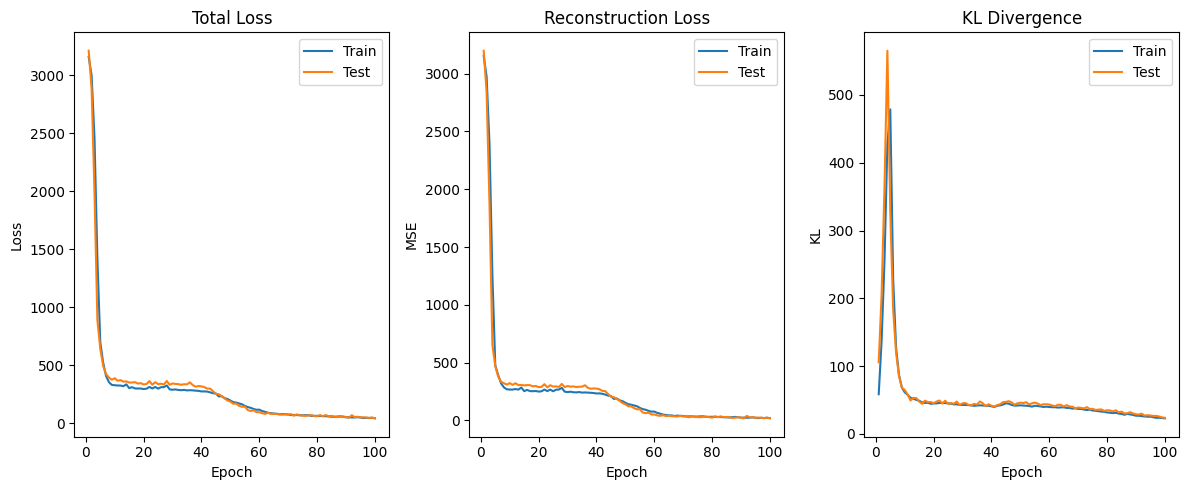

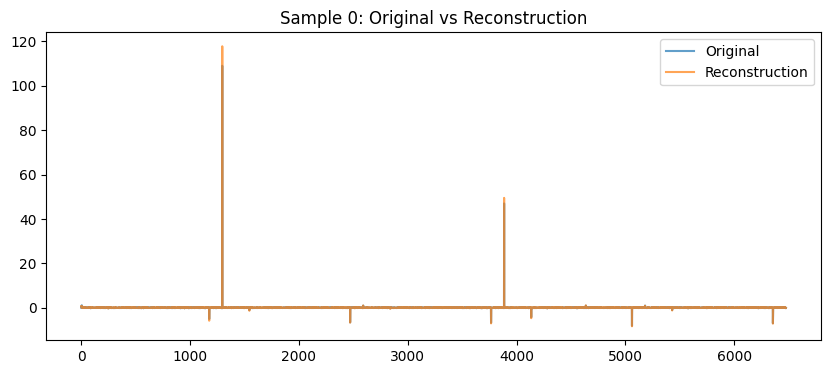

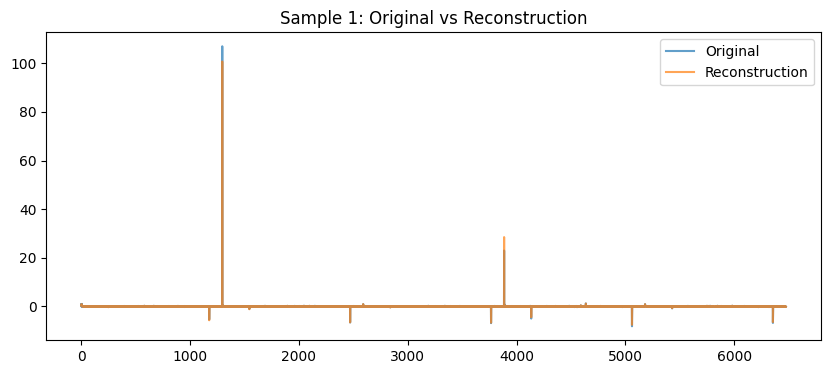

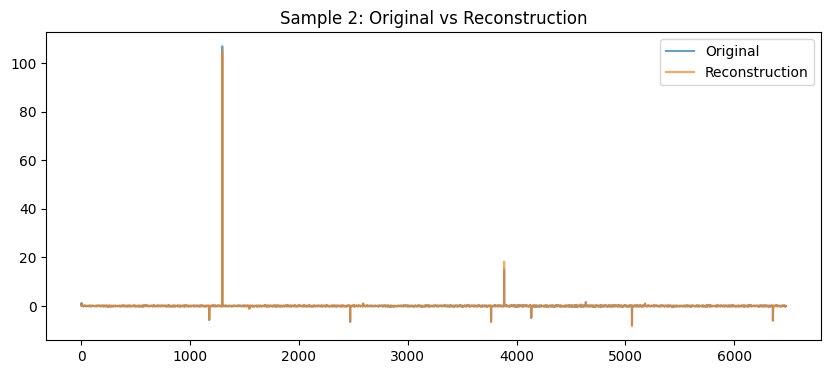

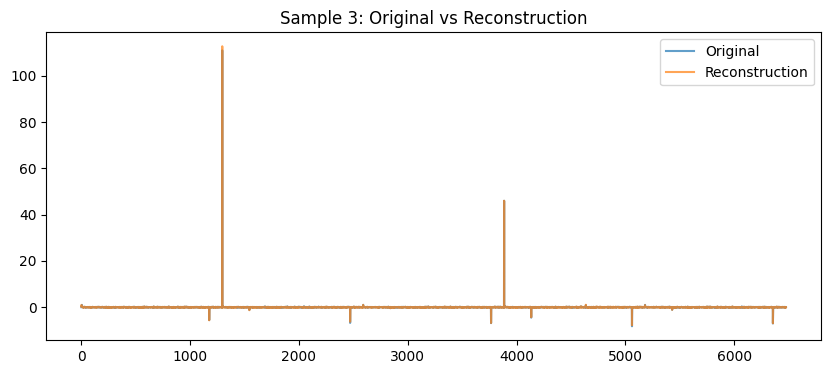

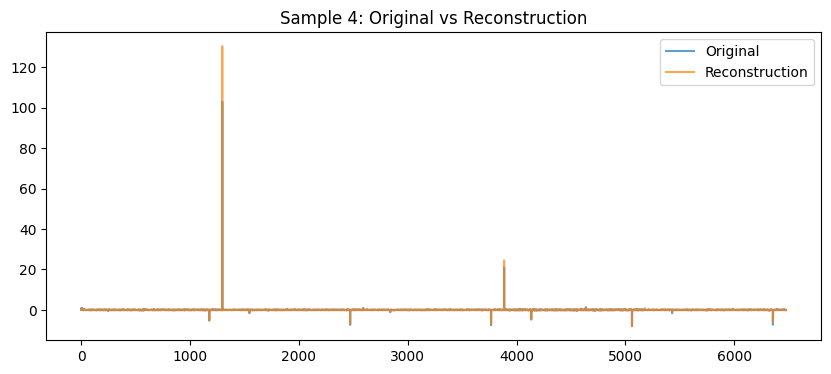

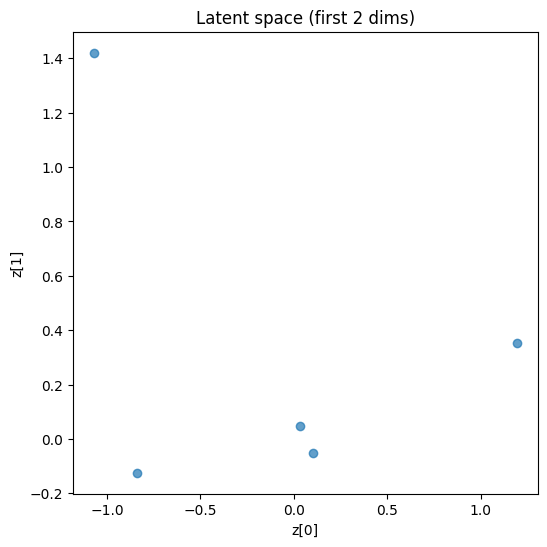

Done. Last train loss: 32.34475326538086
Loss plot saved as 'loss_plot.png'


In [ ]:
if __name__ == "__main__":
    N, R, D = 128, 5, 512
    X = data["features"]
    mask = (np.abs(X).sum(axis=2) > 1e-8).astype(np.float32)

    (xtr, mtr), (xte, mte) = split_train_test(X, test_frac=0.1, seed=17, mask=mask)
    ds_tr = NRPSDataset(xtr, mtr)
    ds_te = NRPSDataset(xte, mte)
    cfg = VAEConfig(
    d_in=1295,
    n_regions=5,
    d_model=256,
    n_heads=8,
    n_layers=2,
    d_ff=512,
    latent_dim=128,
    beta=2,
    kl_warmup_steps=500,
    dropout=0.2,
    decoder_hidden=256,
    per_region_decoders=True,
    lr=1e-4,
    weight_decay=1e-3,
    batch_size=64,
    num_epochs=100,
    use_probe=True,
    probe_weight=0.1
)

    model, hist = train_vae(cfg, ds_tr, ds_te, ckpt_path="./checkpoints/mi_vae.pt", use_early_stopping=False)
    print("Done. Last train loss:", hist["train"][-1]["loss"])
    print("Loss plot saved as 'loss_plot.png'")

In [ ]:
ds_tr.x.shape

torch.Size([1639, 5, 1295])

In [ ]:
import os

os.makedirs('./checkpoints', exist_ok=True)


def mask_one_domain(x, domain_idx):
    """
    Zero out one domain (region) in the input tensor.
    x: [B, regions, features]
    domain_idx: int, which region to mask
    """
    x = x.clone()
    x[:, domain_idx, :] = 0
    return x


def evaluate_model(model, loader, device="cuda"):
    """
    Evaluate a VAE model on a dataset loader.
    Computes baseline reconstruction loss and masked-domain reconstruction loss.
    """
    model.eval()
    model.to(device)

    baseline_losses = []
    mask_losses = []

    with torch.no_grad():
        for x, mask in loader:  # unpack tuple from NRPSDataset
            x = x.to(device)
            mask = mask.to(device) if mask is not None else None

            # --- Baseline reconstruction ---
            out = model(x)
            recon = out["x_hat"]
            baseline_loss = ((x - recon)**2).mean()  # MSE
            baseline_losses.append(baseline_loss.item())

            # --- Mask one domain ---
            domain_idx = torch.randint(0, x.shape[1], (1,)).item()
            masked_x = mask_one_domain(x, domain_idx)
            out_mask = model(masked_x)
            recon_mask = out_mask["x_hat"]
            mask_loss = ((x - recon_mask)**2).mean()
            mask_losses.append(mask_loss.item())

    baseline_mean = np.mean(baseline_losses)
    mask_mean = np.mean(mask_losses)

    return {"baseline": baseline_mean, "mask": mask_mean}


def train_vae_aux(cfg, ds_tr, ds_te, use_aux=True, lambda_aux=0.2, ckpt_path=None):
    model = MultiInputVAE(cfg).to(cfg.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    dl_tr = DataLoader(ds_tr, batch_size=cfg.batch_size, shuffle=True)
    dl_te = DataLoader(ds_te, batch_size=cfg.batch_size, shuffle=False)

    hist = {"train": [], "val": []}

    for epoch in range(cfg.num_epochs):
        model.train()
        total_loss = 0
        for x, mask in dl_tr:  # unpack tuple
            x = x.to(cfg.device)
            mask = mask.to(cfg.device) if mask is not None else None
            optimizer.zero_grad()

            out = model(x)
            recon_loss = ((x - out["x_hat"])**2).mean()

            aux_loss = 0
            if use_aux:
                domain_idx = torch.randint(0, x.shape[1], (1,)).item()
                x_masked = mask_one_domain(x, domain_idx)
                x_hat_masked = model(x_masked)["x_hat"]
                aux_loss = lambda_aux * ((x - x_hat_masked)**2).mean()

            loss = recon_loss + aux_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # evaluation
        model.eval()
        with torch.no_grad():
            res = evaluate_model(model, dl_te, device=cfg.device)

        hist["train"].append({"loss": total_loss/len(dl_tr)})
        hist["val"].append(res)

        print(f"Epoch {epoch+1}/{cfg.num_epochs} | Train Loss: {total_loss/len(dl_tr):.4f} | "
              f"Baseline: {res['baseline']:.3f} | Mask: {res['mask']:.3f}")

    if ckpt_path:
        torch.save(model.state_dict(), ckpt_path)

    return model, hist


model_aux, hist_aux = train_vae_aux(
    cfg,
    ds_tr,
    ds_te,
    use_aux=True,
    lambda_aux=0.2,
    ckpt_path="./checkpoints/mi_vae_aux.pt"
)


Epoch 1/100 | Train Loss: 2.9567 | Baseline: 2.496 | Mask: 2.496
Epoch 2/100 | Train Loss: 2.7868 | Baseline: 2.177 | Mask: 2.175
Epoch 3/100 | Train Loss: 1.8334 | Baseline: 0.689 | Mask: 0.684
Epoch 4/100 | Train Loss: 0.4847 | Baseline: 0.361 | Mask: 0.363
Epoch 5/100 | Train Loss: 0.3671 | Baseline: 0.334 | Mask: 0.335
Epoch 6/100 | Train Loss: 0.3466 | Baseline: 0.307 | Mask: 0.308
Epoch 7/100 | Train Loss: 0.3318 | Baseline: 0.281 | Mask: 0.288
Epoch 8/100 | Train Loss: 0.3036 | Baseline: 0.283 | Mask: 0.288
Epoch 9/100 | Train Loss: 0.2840 | Baseline: 0.251 | Mask: 0.269
Epoch 10/100 | Train Loss: 0.2664 | Baseline: 0.247 | Mask: 0.251
Epoch 11/100 | Train Loss: 0.2561 | Baseline: 0.247 | Mask: 0.256
Epoch 12/100 | Train Loss: 0.2462 | Baseline: 0.236 | Mask: 0.249
Epoch 13/100 | Train Loss: 0.2433 | Baseline: 0.239 | Mask: 0.241
Epoch 14/100 | Train Loss: 0.2547 | Baseline: 0.226 | Mask: 0.326
Epoch 15/100 | Train Loss: 0.2312 | Baseline: 0.229 | Mask: 0.325
Epoch 16/100 | Trai

#Saving the model

In [ ]:
import torch
import os
from google.colab import files

# Ensure the folder exists
os.makedirs('./checkpoints', exist_ok=True)

# Save the model's state_dict
torch.save(model_aux.state_dict(), './checkpoints/MI-vae_vI_aux.pth')
files.download("./checkpoints/MI-vae_vI_aux.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Evaluation

In [ ]:
if __name__ == "__main__":
    N, R, D = 128, 5, 512
    X = data["features"]
    mask = (np.abs(X).sum(axis=2) > 1e-8).astype(np.float32)

    (xtr, mtr), (xte, mte) = split_train_test(X, test_frac=0.1, seed=17, mask=mask)
    ds_tr = NRPSDataset(xtr, mtr)
    ds_te = NRPSDataset(xte, mte)
    cfg = VAEConfig(
    d_in=1295,
    n_regions=5,
    d_model=256,
    n_heads=8,
    n_layers=2,
    d_ff=512,
    latent_dim=128,
    beta=2,
    kl_warmup_steps=500,
    dropout=0.2,
    decoder_hidden=256,
    per_region_decoders=True,
    lr=1e-4,
    weight_decay=1e-3,
    batch_size=64,
    num_epochs=100,
    use_probe=True,
    probe_weight=0.1
)
model = MultiInputVAE(cfg).to(cfg.device)

In [ ]:
model.load_state_dict(torch.load("/content/MI-vae-v1_checkpoint.pt"))
model.eval()

MultiInputVAE(
  (encoder): MultiRegionEncoder(
    (input_proj): Linear(in_features=1295, out_features=256, bias=True)
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=512, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=512, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (dropout2): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (segpos): SegmentPositionalEmbedding(
      (proj): Linear(in_features=1, out_features=256, bias=True)
      (segment): Embedding(5, 256)
 

Shuffling and circulr constructun

In [ ]:
import torch
import numpy as np
from tqdm import tqdm


def mask_one_domain(x, domain_idx=2):
    x = x.clone()
    x[:, domain_idx, :] = 0
    return x
def shuffle_domains(x):

    idx = torch.randperm(x.size(1))
    return x[:, idx, :]


def recon_loss(pred, target, mask):
    diff = (pred - target) ** 2
    diff = diff.sum(dim=-1)
    masked = diff * mask
    return masked.sum() / mask.sum()

@torch.no_grad()
def evaluate_model(model, loader, device="cuda"):
    model.eval()
    baseline_losses, mask_losses, shuffle_losses = [], [], []

    for x, mask in tqdm(loader, desc="Evaluating"):
        x, mask = x.to(device), mask.to(device)
        out = model(x)
        recon = out["x_hat"]
        baseline_loss = recon_loss(recon, x, mask)

        masked_x = mask_one_domain(x)
        out_mask = model(masked_x)
        recon_mask = out_mask["x_hat"]
        mask_loss = recon_loss(recon_mask, x, mask)
        shuffled_x = shuffle_domains(x)
        out_shuffle = model(shuffled_x)
        recon_shuffle = out_shuffle["x_hat"]
        shuffle_loss = recon_loss(recon_shuffle, x, mask)

        baseline_losses.append(baseline_loss.item())
        mask_losses.append(mask_loss.item())
        shuffle_losses.append(shuffle_loss.item())

    results = {
        "baseline": np.mean(baseline_losses),
        "mask": np.mean(mask_losses),
        "shuffle": np.mean(shuffle_losses)
    }
    return results




In [ ]:
from torch.utils.data import DataLoader

dl_tr = DataLoader(ds_tr, batch_size=100, shuffle=False)
dl_te = DataLoader(ds_te, batch_size=100, shuffle=False)

res_train = evaluate_model(model, dl_tr, device="cuda")
res_test  = evaluate_model(model, dl_te, device="cuda")

print("Train:", res_train)
print("Test:", res_test)


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 91.94it/s]

Train: {'baseline': np.float64(20.75718526279225), 'mask': np.float64(19.600859754225787), 'shuffle': np.float64(330.7825647802914)}
Test: {'baseline': np.float64(17.688714504241943), 'mask': np.float64(21.058122634887695), 'shuffle': np.float64(208.81589126586914)}


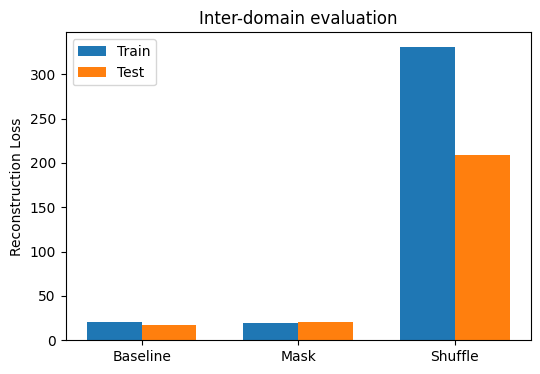

In [ ]:
import matplotlib.pyplot as plt

def plot_eval_results(res_train, res_test):
    labels = ["Baseline", "Mask", "Shuffle"]
    train_vals = [res_train["baseline"], res_train["mask"], res_train["shuffle"]]
    test_vals  = [res_test["baseline"],  res_test["mask"],  res_test["shuffle"]]

    x = np.arange(len(labels))  # label positions
    width = 0.35

    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(x - width/2, train_vals, width, label="Train")
    ax.bar(x + width/2, test_vals,  width, label="Test")

    ax.set_ylabel("Reconstruction Loss")
    ax.set_title("Inter-domain evaluation")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.show()

plot_eval_results(res_train, res_test)


Shuffling and circular constructun within each domain

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

def mask_one_domain(x, domain_idx=2):
    x = x.clone()
    x[:, domain_idx, :] = 0
    return x

def shuffle_domains(x):
    idx = torch.randperm(x.size(1))
    return x[:, idx, :]

def recon_loss_per_domain(pred, target, mask):
    """
    Returns a tensor of size (batch, n_domains) containing
    the reconstruction loss per domain.
    """
    diff = (pred - target) ** 2  # [batch, n_domains, features]
    diff = diff.sum(dim=-1)      # sum over features -> [batch, n_domains]
    masked = diff * mask          # apply mask
    # mean over masked elements per domain
    domain_loss = masked.sum(dim=0) / (mask.sum(dim=0) + 1e-8)
    return domain_loss

@torch.no_grad()
def evaluate_model_detailed(model, loader, device="cuda"):
    model.eval()
    all_baseline, all_mask, all_shuffle = [], [], []

    for x, mask in tqdm(loader, desc="Evaluating"):
        x, mask = x.to(device), mask.to(device)

        # Baseline
        out = model(x)
        recon = out["x_hat"]
        baseline_loss = recon_loss_per_domain(recon, x, mask)
        all_baseline.append(baseline_loss.cpu().numpy())

        # Mask one domain
        masked_x = mask_one_domain(x)
        out_mask = model(masked_x)
        recon_mask = out_mask["x_hat"]
        mask_loss = recon_loss_per_domain(recon_mask, x, mask)
        all_mask.append(mask_loss.cpu().numpy())

        # Shuffle domains
        shuffled_x = shuffle_domains(x)
        out_shuffle = model(shuffled_x)
        recon_shuffle = out_shuffle["x_hat"]
        shuffle_loss = recon_loss_per_domain(recon_shuffle, x, mask)
        all_shuffle.append(shuffle_loss.cpu().numpy())

    results = {
        "baseline": np.mean(all_baseline, axis=0),
        "mask": np.mean(all_mask, axis=0),
        "shuffle": np.mean(all_shuffle, axis=0)
    }
    return results


In [ ]:
from torch.utils.data import DataLoader

dl_tr = DataLoader(ds_tr, batch_size=100, shuffle=False)
dl_te = DataLoader(ds_te, batch_size=100, shuffle=False)

res_train = evaluate_model_detailed(model, dl_tr, device="cuda")
res_test  = evaluate_model_detailed(model, dl_te, device="cuda")

print("Train:", res_train)
print("Test:", res_test)


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 57.97it/s]

Train: {'baseline': array([ 3.2947063, 58.393955 ,  1.5037128, 30.518026 ,  2.131844 ],
      dtype=float32), 'mask': array([ 3.29954  , 63.019985 ,  1.5051821, 30.788286 ,  2.1178472],
      dtype=float32), 'shuffle': array([   3.7429411, 1088.2068   ,    1.7651044, 1322.0948   ,
          3.4457011], dtype=float32)}
Test: {'baseline': array([ 3.1890578, 45.945015 ,  1.4346124, 38.67784  ,  2.0946832],
      dtype=float32), 'mask': array([ 3.1784077, 44.407288 ,  1.4394898, 47.271015 ,  2.0870967],
      dtype=float32), 'shuffle': array([  4.03368  , 473.3662   ,   1.8050218, 259.22687  ,   3.2232864],
      dtype=float32)}


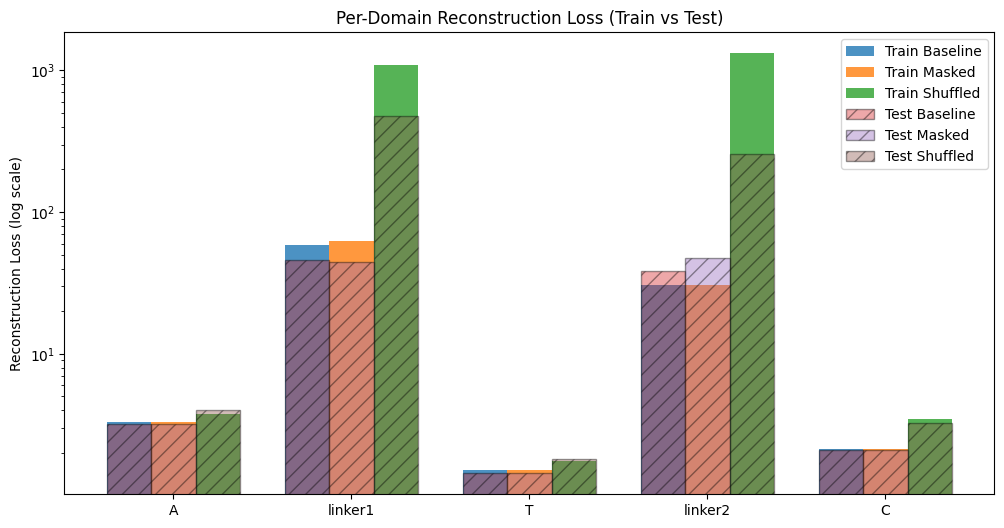

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

domain_names = ["A","linker1","T","linker2","C"]

# Arrays from your results
train_baseline = res_train["baseline"]
train_mask = res_train["mask"]
train_shuffle = res_train["shuffle"]

test_baseline = res_test["baseline"]
test_mask = res_test["mask"]
test_shuffle = res_test["shuffle"]

x = np.arange(len(domain_names))
width = 0.25

plt.figure(figsize=(12,6))

# Train bars
plt.bar(x - width, train_baseline, width, label="Train Baseline", alpha=0.8)
plt.bar(x, train_mask, width, label="Train Masked", alpha=0.8)
plt.bar(x + width, train_shuffle, width, label="Train Shuffled", alpha=0.8)

# Test bars on top but slightly transparent
plt.bar(x - width, test_baseline, width, label="Test Baseline", alpha=0.4, edgecolor='black', hatch="//")
plt.bar(x, test_mask, width, label="Test Masked", alpha=0.4, edgecolor='black', hatch="//")
plt.bar(x + width, test_shuffle, width, label="Test Shuffled", alpha=0.4, edgecolor='black', hatch="//")

plt.yscale("log")  # log scale to handle huge differences
plt.xticks(x, domain_names)
plt.ylabel("Reconstruction Loss (log scale)")
plt.title("Per-Domain Reconstruction Loss (Train vs Test)")
plt.legend()
plt.show()


In [ ]:
def mask_except(x, keep_idxs):
    """
    Mask all domains except the ones in keep_idxs.
    """
    x_masked = x.clone()
    all_idxs = set(range(x.size(1)))
    mask_idxs = list(all_idxs - set(keep_idxs))
    x_masked[:, mask_idxs, :] = 0
    return x_masked

@torch.no_grad()
def conditional_recon_loss(model, loader, domain_idx, cond_idxs, device="cuda"):
    """
    Compute reconstruction loss for a specific domain conditioned on other domains.
    """
    model.eval()
    losses = []

    for x, mask in loader:
        x, mask = x.to(device), mask.to(device)
        x_cond = mask_except(x, cond_idxs)
        out = model(x_cond)
        recon = out["x_hat"]
        # Only compute loss for the target domain
        domain_mask = mask[:, domain_idx:domain_idx+1, :]
        domain_target = x[:, domain_idx:domain_idx+1, :]
        loss = recon_loss(recon[:, domain_idx:domain_idx+1, :], domain_target, domain_mask)
        losses.append(loss.item())

    return np.mean(losses)


In [ ]:
dl_te = DataLoader(ds_te, batch_size=100, shuffle=False)

loss_d2 = conditional_recon_loss(model, dl_te, domain_idx=2, cond_idxs=[1,3], device="cuda")
loss_d4 = conditional_recon_loss(model, dl_te, domain_idx=4, cond_idxs=[3,5], device="cuda")

print("Domain 2 conditioned on 1 & 3:", loss_d2)
print("Domain 4 conditioned on 3 & 5:", loss_d4)


IndexError: too many indices for tensor of dimension 2

#Anomally detection

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from tqdm import tqdm

# Assume your model classes (VAEConfig, MultiInputVAE, etc.) are defined above this code

class AnomalyScorer:
    """
    Designs and computes an anomaly score for the MultiInputVAE.

    This scorer combines two main components:
    1. Weighted Reconstruction Error: Tailored for the multi-input nature of the model,
       this score weights errors in each region based on how hard that region is to
       reconstruct on average. It amplifies significant deviations in normally stable regions.
    2. Latent Space Density: It models the distribution of 'normal' data in the latent
       space using a Gaussian Mixture Model. Samples that fall into low-density areas
       are considered anomalous.

    The final score is a weighted combination of these two normalized components.
    """
    def __init__(self, model: MultiInputVAE, cfg: VAEConfig):
        self.model = model
        self.cfg = cfg
        self.model.eval()
        self.device = cfg.device

        # These will be fitted on the normal training data
        self.beta_weights = None
        self.gmm = None
        self.scaler_recon = StandardScaler()
        self.scaler_latent = StandardScaler()

    def fit(self, train_loader: DataLoader):
        """
        Fit the scorer on normal data. This calculates the beta weights for the
        reconstruction score and fits the GMM for the latent score.
        """
        print("Fitting Anomaly Scorer on normal training data...")

        all_z = []
        # A list of lists, where each inner list holds errors for a region
        per_region_errors = [[] for _ in range(self.cfg.n_regions)]

        with torch.no_grad():
            for xb, mb in tqdm(train_loader, desc="Calculating stats"):
                xb, mb = xb.to(self.device), mb.to(self.device)

                out = self.model(xb, mb)
                x_hat, z = out["x_hat"], out["z"]

                # Store latent vectors
                all_z.append(z.cpu().numpy())

                # Calculate and store per-region reconstruction errors (MSE)
                # Shape: (B, R, D) -> (B, R)
                errors = F.mse_loss(x_hat, xb, reduction='none').mean(dim=-1)

                # Apply mask: we only consider errors for present regions
                # The mask `mb` has shape (B, R)
                masked_errors = errors * mb

                # Iterate over batch and regions to collect valid errors
                for b in range(xb.size(0)):
                    for r in range(self.cfg.n_regions):
                        if mb[b, r] > 0: # If the region is present
                            per_region_errors[r].append(masked_errors[b, r].item())

        # --- 1. Compute Beta Weights for Reconstruction Score ---
        # Calculate the average error for each region
        avg_region_errors = np.array([np.mean(errs) if errs else 1.0 for errs in per_region_errors])

        # Calculate the global average error
        global_avg_error = np.mean(avg_region_errors)

        # Calculate beta weights (inverse proportionality)
        # Add a small epsilon to avoid division by zero
        self.beta_weights = global_avg_error / (avg_region_errors + 1e-8)
        self.beta_weights = torch.from_numpy(self.beta_weights).float().to(self.device)
        print(f"Computed Beta Weights per region: {self.beta_weights.cpu().numpy()}")

        # --- 2. Fit GMM on Latent Space ---
        all_z_np = np.concatenate(all_z, axis=0)
        # Using K=5 as suggested in the paper, but this can be tuned
        print(f"Fitting GMM (K=5) on {all_z_np.shape[0]} latent vectors...")
        self.gmm = GaussianMixture(n_components=5, random_state=42, covariance_type='diag')
        self.gmm.fit(all_z_np)

        # --- 3. Fit Scalers for Normalization ---
        # We need to calculate the raw scores for the training data to fit the scalers
        print("Calculating raw scores for normalization...")
        raw_recon_scores = []
        raw_latent_scores = []

        with torch.no_grad():
            for xb, mb in tqdm(train_loader, desc="Normalizing scores"):
                xb, mb = xb.to(self.device), mb.to(self.device)
                recon_s, latent_s = self._get_raw_scores(xb, mb)
                raw_recon_scores.append(recon_s.cpu().numpy())
                raw_latent_scores.append(latent_s) # Already a numpy array

        self.scaler_recon.fit(np.concatenate(raw_recon_scores).reshape(-1, 1))
        self.scaler_latent.fit(np.concatenate(raw_latent_scores).reshape(-1, 1))
        print("Anomaly Scorer is ready.")

    def _get_raw_scores(self, xb: torch.Tensor, mb: torch.Tensor) -> Tuple[torch.Tensor, np.ndarray]:
        """Helper to compute the two un-normalized score components."""
        out = self.model(xb, mb)
        x_hat, z = out["x_hat"], out["z"]

        # Raw weighted reconstruction score
        per_region_mse = F.mse_loss(x_hat, xb, reduction='none').mean(dim=-1) # (B, R)
        weighted_errors = per_region_mse * self.beta_weights.unsqueeze(0)

        # Apply mask and sum over regions
        score_recon = (weighted_errors * mb).sum(dim=1) / (mb.sum(dim=1) + 1e-8)

        # Raw latent density score (log-likelihood)
        score_latent = self.gmm.score_samples(z.cpu().numpy())

        return score_recon, score_latent

    def score(self, data_loader: DataLoader, w_recon: float = 1.0, w_latent: float = 1.0) -> np.ndarray:
        """
        Calculates the final anomaly score for a given dataset.

        Args:
            data_loader: DataLoader for the dataset to be scored.
            w_recon: Weight for the reconstruction score component.
            w_latent: Weight for the latent density score component.

        Returns:
            A numpy array of final anomaly scores for each sample.
        """
        if self.gmm is None or self.beta_weights is None:
            raise RuntimeError("Scorer has not been fitted. Call .fit(train_loader) first.")

        self.model.eval()
        final_scores = []

        with torch.no_grad():
            for xb, mb in tqdm(data_loader, desc="Scoring samples"):
                xb, mb = xb.to(self.device), mb.to(self.device)

                score_recon_raw, score_latent_raw = self._get_raw_scores(xb, mb)

                # Normalize scores
                norm_recon = self.scaler_recon.transform(score_recon_raw.cpu().numpy().reshape(-1, 1))
                norm_latent = self.scaler_latent.transform(score_latent_raw.reshape(-1, 1))

                # Combine scores: higher is more anomalous
                # Note the minus sign for latent score, as low log-likelihood is anomalous
                combined_score = (w_recon * norm_recon) - (w_latent * norm_latent)
                final_scores.append(combined_score.flatten())

        return np.concatenate(final_scores)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression

# --- USAGE EXAMPLE ---

# 1. First, train your VAE model as you did before
# model, hist = train_vae(cfg, ds_tr, ds_te, ...)

# 2. Create the scorer and fit it on the NORMAL training data
# NOTE: Use a DataLoader with the same batch size as training for consistency
dl_tr_for_scorer = DataLoader(ds_tr, batch_size=cfg.batch_size, shuffle=False)
scorer = AnomalyScorer(model, cfg)
scorer.fit(dl_tr_for_scorer)

# 3. Score your test set (or any new data)
dl_te = DataLoader(ds_te, batch_size=cfg.batch_size, shuffle=False)
raw_anomaly_scores = scorer.score(dl_te)

# Assume you have labels for your test set to see how well it works
# y_test = ... (0 for normal, 1 for anomaly)
# from sklearn.metrics import roc_auc_score
# print(f"AUC Score: {roc_auc_score(y_test, raw_anomaly_scores)}")


# --- CALIBRATION ---

# 4. Assume you have a calibration set (X_calib, y_calib)
# You would create a DataLoader for it: ds_calib = NRPSDataset(X_calib, m_calib)
# dl_calib = DataLoader(ds_calib, batch_size=cfg.batch_size)

# Get the raw scores for the calibration set
# calib_scores = scorer.score(dl_calib).reshape(-1, 1)

# Fit a calibration model (Platt Scaling)
# platt_scaler = LogisticRegression()
# platt_scaler.fit(calib_scores, y_calib)

# Now you can get probabilities for your test scores
# test_scores_reshaped = raw_anomaly_scores.reshape(-1, 1)
# probabilities = platt_scaler.predict_proba(test_scores_reshaped)[:, 1]

# --- DECISION BAND ---
# As recommended, use a decision band instead of a hard threshold
def classify_sample(probability: float):
    if probability > 0.75: # High threshold
        return "Likely Anomaly"
    elif probability < 0.25: # Low threshold
        return "Likely Normal"
    else:
        return "Uncertain (Requires Review)"

for p in probabilities[:10]:
   print(f"Probability: {p:.3f} -> Classification: {classify_sample(p)}")